In [1]:
import crispr_assembler as ca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

%load_ext autoreload
%autoreload 2

import pickle

In [2]:
def process_path(path, cut = -1, save = 1):
    pairs_path = path + "/out/pairs/"
    files = sorted(os.listdir(pairs_path))
    
    print(pairs_path + files[0])
    
    read = ca.Read(pairs_path + files[0])
    read.correct_errors(minimum_occurences=5)
    gr = read.graph_from_pairs()[0]
    
    print('calc embs')
    ec = ca.EmbeddingsCalculator()
    ec.make_argsorts(gr[:cut, :cut])
    embs = ec.fit_predict(gr[:cut, :cut], njobs=32)
    
    if save:
        pickle.dump(read, open(path + "/read", 'wb'))
        np.save(path + "/graph", gr)
        np.save(path + "/embs", embs)
        
    return read, gr, embs

In [3]:
def load(path):
    return pickle.load(open(path + "/read", 'rb')), np.load(path + "/graph.npy"), np.load(path + "/embs.npy")

In [4]:
def unwrap_idx_to_spacer(idx_to_spacer):
    values_as_list = []
    for i in range(len(idx_to_spacer)):
        values_as_list.append(idx_to_spacer[i])
    return values_as_list

In [5]:
def continue_steps(reads, pointers):
    return any([pointers[i] < len(reads[i]) for i in range(len(reads))])

In [6]:
def merge_reads(reads, t=1, v = 1):
    spacers_lists = [unwrap_idx_to_spacer(x) for x in reads]#[unwrap_idx_to_spacer(x.index_to_cluster) for x in reads]
    pointers = [0 for i in range(len(reads))]
    merged_sp_to_idxes = {}
    old_idx_to_new_idx = [{} for i in range(len(reads))]
    
    curr = 0
    while continue_steps(spacers_lists, pointers):
        for i in range(len(reads)):
            if pointers[i] < len(reads[i]):
                spacer = spacers_lists[i][pointers[i]]
                
                dist, closest = ca.find_closest(merged_sp_to_idxes, spacer)
                if dist > t:
                    merged_sp_to_idxes[spacer] = curr
                    #new_sp_to_ids[i][spacer] = curr
                    old_idx_to_new_idx[i][pointers[i]] = curr
                    curr += 1
                else:
                    old_idx_to_new_idx[i][pointers[i]] = merged_sp_to_idxes[closest]
                
                pointers[i] += 1
                
                if curr % 100 == 0:
                    print(curr)
                

                if v:
                    print(i, pointers[i], spacer, dist, merged_sp_to_idxes)#, new_sp_to_ids[1])
                    
    return merged_sp_to_idxes,  old_idx_to_new_idx

In [7]:
def rearange(gr, order):
    new_gr = np.zeros((max(order.values()) + 1, max(order.values()) + 1))

    for i in tqdm.tqdm(range(len(order.keys()))):
        for j in range(len(order.keys())):
            new_gr[order[i], order[j]] = gr[i, j]

    return new_gr

In [8]:
read_slv, gr_slv, emb_slv = process_path("../../data/environmental/slo2/")

../../data/environmental/slo2//out/pairs/SlO2_ACTGAT_L001_R1_001.fastq.gz_pairs.txt


100%|██████████| 1065/1065 [00:01<00:00, 939.91it/s]


calc embs


In [9]:
#answer_sensivity = ca.read_arrays_with_tags("../../article/data/answers/sensivity", 0)
answer = ca.read_arrays_with_tags("../../article/data/answers/all", 0)

In [10]:
a, d = ca.multiple_arrays_to_ids(answer, read_slv.spacer_to_cluster_index)

#a_all, d_all = ca.multiple_arrays_to_ids(answer_all, res.spacer_to_cluster_index)

answ_gr = ca.graph_from_arrays([x for x in a.values()], gr_slv.shape[0])[0]

100%|██████████| 54/54 [00:01<00:00, 37.79it/s]


In [11]:
d

{'first_1': [0, 0, 0, 13, 13, 0, 13],
 'first_11': [0, 0, 0, 13, 13, 0, 13],
 'first_2': [2, 2, 2, 2, 2],
 'first_24': [2, 2, 2, 2, 2],
 'first_61': [2, 2, 2, 2, 2],
 'first_62': [2, 2, 2, 2, 2],
 'first_68': [2, 2, 2, 2, 2],
 'first_3': [1, 1, 1, 12, 12, 13, 13],
 'first_5': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'first_50': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'first_7': [12, 1, 12, 2, 12, 13, 13, 13, 13],
 'first_8': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'first_14': [0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0],
 'first_15': [0, 0, 0, 0, 13, 13, 0, 12, 14, 0, 0, 13, 0, 0, 0, 0, 0, 0, 14],
 'first_19': [0, 0, 0, 0, 0, 0, 0, 0],
 'first_20': [0, 0, 0, 0, 0, 0, 0, 0],
 'first_22': [0, 0, 0, 0, 0, 0, 0, 0],
 'first_31': [0, 0, 0, 0, 0, 0, 0, 0],
 'first_21': [0, 0, 12, 13, 13, 0, 14, 0, 0, 12, 13],
 'first_23': [0, 0, 12, 13, 13, 0, 14, 0, 0, 12, 13],
 'first_27': [0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 14, 13, 14],
 'first_65': [0, 0, 12, 13, 13, 0, 14, 0, 0, 12],
 'first_70': [0, 0, 12, 13, 13, 0, 14

In [12]:
arrays_found_d = []
for k,v in d.items():
    if max(sorted(v)[::-1][:]) < 3:
        arrays_found_d.append(k)

In [13]:
arrays_found_v = []
for k,v in a.items():
    #print(k, sorted(v)[::-1])
    if max(sorted(v)[::-1][1:]) < 300:
        arrays_found_v.append(k)

In [14]:
arrays_found_d

['first_2',
 'first_24',
 'first_61',
 'first_62',
 'first_68',
 'first_5',
 'first_50',
 'first_8',
 'first_19',
 'first_20',
 'first_22',
 'first_31',
 'first_9',
 'first_66',
 'second_1',
 'second_11',
 'second_67']

In [15]:
set(arrays_found_v).intersection(set(arrays_found_d))

{'first_19',
 'first_20',
 'first_22',
 'first_31',
 'first_66',
 'first_8',
 'first_9',
 'second_1',
 'second_11',
 'second_67'}

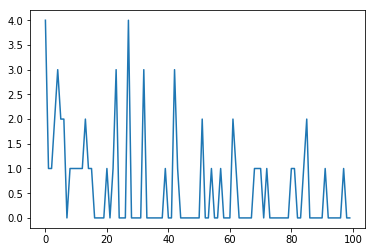

In [16]:
plt.plot((answ_gr > 0).sum(1)[:100])

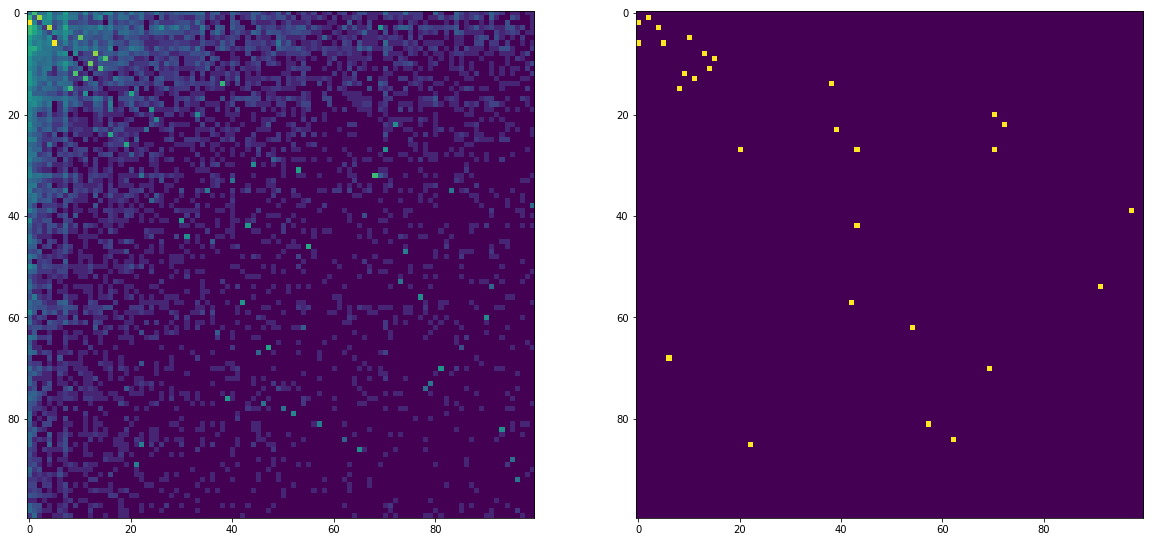

In [17]:
cut1 = 0
cut2 = 100
ca.plot_grs(gr_slv[cut1:cut2, cut1:cut2],
           (answ_gr[cut1:cut2, cut1:cut2] > 0).astype(int),
#             grs_m[1][:cut, :cut],
#             grs_m[2][:cut, :cut],
            log = 1, 
            s = 20)
plt.show()

In [18]:
gb = pickle.load(open("../article/linear_svc_rep_to_rep", 'rb'))

#pred = gb.predict(embs[0]).reshape((grs[0].shape[0] - 1, grs[0].shape[1] - 1))

In [19]:
pred = gb.predict(emb_slv).reshape((gr_slv.shape[0] - 1, gr_slv.shape[1] - 1))

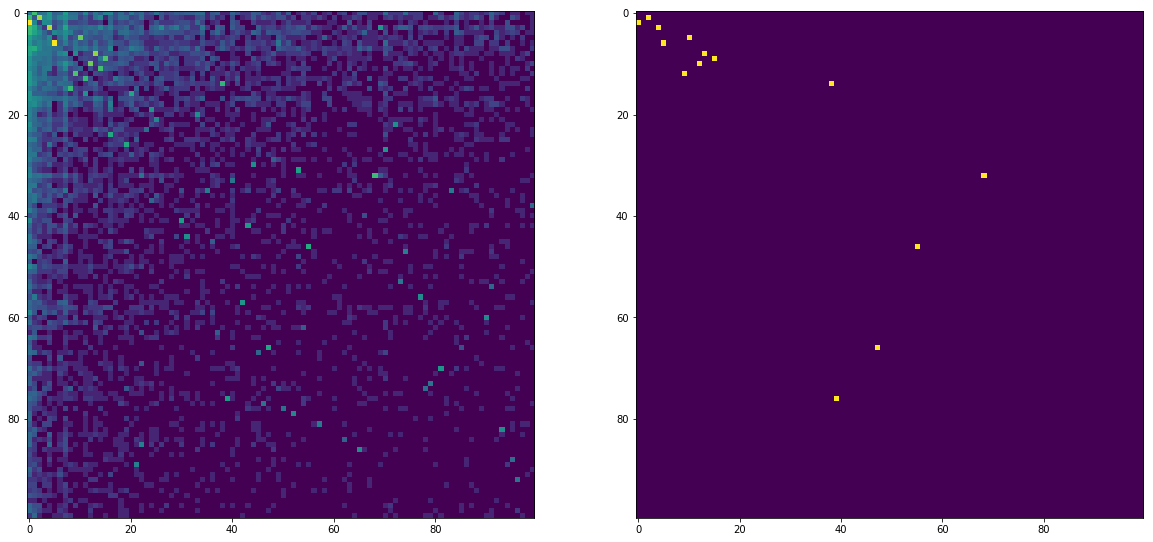

In [20]:
cut = 100
ca.plot_grs(gr_slv[:cut, :cut],
            pred[:cut, :cut],
            log = 1, 
            s = 20, subplots_form = (1,2))
plt.show()

In [25]:
arrs_slv = [x for x in ca.restore_arrays_greedy(gr_slv, 2)[0] if len(x) > 2]

In [26]:
arrs_slv

[[17, 3, 4, 7, 1, 2, 0, 129],
 [32, 68, 6, 5, 10, 12, 9, 15, 8, 13, 11, 14, 38, 99],
 [135,
  226,
  82,
  93,
  115,
  56,
  77,
  46,
  55,
  100,
  71,
  162,
  151,
  141,
  237,
  87,
  117,
  304],
 [484, 18, 26, 19, 24, 16, 20, 33, 40, 66, 47, 74, 78, 50],
 [41, 30, 44, 31, 53, 73, 79, 52, 132],
 [76, 39, 101],
 [27, 70, 81, 57, 42, 43, 152],
 [85, 22, 72, 108],
 [348, 246, 163, 202, 86, 65, 170],
 [148, 138, 121, 145, 322],
 [122, 61, 102, 137],
 [310, 315, 206, 124, 60, 90, 133, 59],
 [359, 208, 107, 92, 96, 114],
 [89, 21, 25, 196, 120],
 [182, 119, 205, 183, 213, 88, 95, 291, 328],
 [49, 134, 63, 109, 150, 37, 111, 147, 286],
 [212, 169, 261, 176, 172, 153],
 [233, 125, 171, 278],
 [123, 98, 158],
 [186, 189, 248],
 [83, 110, 303],
 [149, 128, 166, 251, 156, 247],
 [140, 75, 142, 161],
 [192, 200, 146, 319],
 [191, 230, 383],
 [321, 287, 239],
 [307, 104, 216],
 [285, 164, 327],
 [297, 255, 266, 277],
 [105, 28, 143],
 [252, 193, 84, 62, 54, 91],
 [313, 214, 178, 270],
 [67,

In [56]:
ca.print_alignments(ca.water_alignments(v, arrs_slv), v)

[' 95 , 36 , 198, 104, 16 ,']

In [54]:
v

[95, 36, 198, 104, 16]